## Natural Gas Future

In [1]:
import pandas as pd

In [2]:
naturalgas = pd.read_csv("Natural_Gas_Futures_Contract_2.csv")

In [3]:
naturalgas.head(5)

Day  Natural Gas Futures Contract 1  Dollars per Million Btu
0  12/29/2017                                              2.953      
1  12/28/2017                                              2.914      
2  12/27/2017                                              2.738      
3  12/26/2017                                              2.643      
4  12/22/2017                                              2.667

### Part 1 Data Preperation

#### 1.1 Reorder the data

In [4]:
naturalgas['Day'] =pd.to_datetime(naturalgas['Day'])

In [5]:
naturalgas.head(5)

Day  Natural Gas Futures Contract 1  Dollars per Million Btu
0 2017-12-29                                              2.953      
1 2017-12-28                                              2.914      
2 2017-12-27                                              2.738      
3 2017-12-26                                              2.643      
4 2017-12-22                                              2.667

In [6]:
naturalgas=naturalgas.sort_values(by='Day')

In [7]:
naturalgas.head(5)

Day  Natural Gas Futures Contract 1  Dollars per Million Btu
6001 1994-01-13                                              2.194      
6000 1994-01-14                                              2.268      
5999 1994-01-17                                              2.360      
5998 1994-01-18                                              2.318      
5997 1994-01-19                                              2.252

In [8]:
naturalgas.count()

Day                                                        6002
Natural Gas Futures Contract 1  Dollars per Million Btu    6002
dtype: int64

#### 1.2 Impute missing value

In [9]:
Date = pd.bdate_range('1994-01-13', '2017-12-29')

In [10]:
type(Date)

pandas.core.indexes.datetimes.DatetimeIndex

In [11]:
Date = Date.strftime('%Y-%m-%d')

In [12]:
Date = pd.DataFrame(Date)

In [13]:
Date.head(5)

0
0  1994-01-13
1  1994-01-14
2  1994-01-17
3  1994-01-18
4  1994-01-19

In [14]:
Date.columns = ['Day']

In [15]:
Date.head(5)

Day
0  1994-01-13
1  1994-01-14
2  1994-01-17
3  1994-01-18
4  1994-01-19

In [16]:
Date.tail(5)

Day
6247  2017-12-25
6248  2017-12-26
6249  2017-12-27
6250  2017-12-28
6251  2017-12-29

In [17]:
Date['Day'] =pd.to_datetime(Date['Day'])

In [18]:
Date.count()

Day    6252
dtype: int64

In [19]:
gas = pd.merge(Date, naturalgas, how='left', on=['Day'])

In [20]:
gas.count()

Day                                                        6252
Natural Gas Futures Contract 1  Dollars per Million Btu    6002
dtype: int64

In [21]:
gas.head()

Day  Natural Gas Futures Contract 1  Dollars per Million Btu
0 1994-01-13                                              2.194      
1 1994-01-14                                              2.268      
2 1994-01-17                                              2.360      
3 1994-01-18                                              2.318      
4 1994-01-19                                              2.252

In [22]:
gas.columns = ['Day','Price']

In [23]:
gas['Price'].isnull().sum()

250

In [24]:
gas = gas.fillna(method='ffill')

In [25]:
gas['Price'].isnull().sum()

0

In [26]:
gas.to_csv("gas4.csv", index= False)

#### 1.3 Plotting

In [27]:
import matplotlib.pyplot as plt

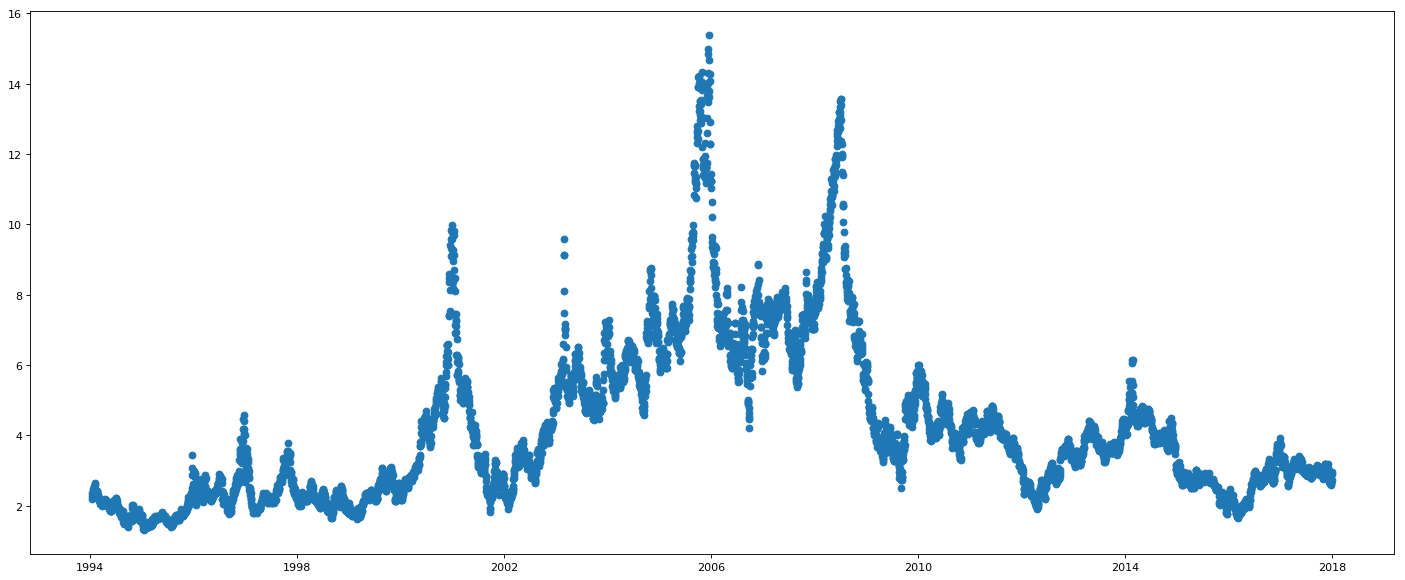

In [28]:
fig=plt.figure(figsize=(22, 9), dpi= 80, facecolor='w', edgecolor='k')
plt.plot_date(x=gas.Day, y=gas.Price)
plt.show()

### Part 2 Modeling

#### 2.1 Split into training and testing data. Testing data starts from 2017-01-02.

In [29]:
df = pd.read_csv('gas4.csv')

In [30]:
#df.Timestamp = pd.to_datetime(df.Day) 
#df.index = df.Timestamp

In [30]:
df.Timestamp = pd.date_range('1994-1-13', periods=6252, freq='B')
df.index = df.Timestamp

In [31]:
df.index

DatetimeIndex(['1994-01-13', '1994-01-14', '1994-01-17', '1994-01-18',
               '1994-01-19', '1994-01-20', '1994-01-21', '1994-01-24',
               '1994-01-25', '1994-01-26',
               ...
               '2017-12-18', '2017-12-19', '2017-12-20', '2017-12-21',
               '2017-12-22', '2017-12-25', '2017-12-26', '2017-12-27',
               '2017-12-28', '2017-12-29'],
              dtype='datetime64[ns]', length=6252, freq='B')

In [32]:
train=df[0:5992] 
test=df[5992:]

In [33]:
train.tail(5)

Day  Price
2016-12-26  2016-12-26  3.662
2016-12-27  2016-12-27  3.761
2016-12-28  2016-12-28  3.930
2016-12-29  2016-12-29  3.802
2016-12-30  2016-12-30  3.724

In [34]:
test.head(5)

Day  Price
2017-01-02  2017-01-02  3.724
2017-01-03  2017-01-03  3.327
2017-01-04  2017-01-04  3.267
2017-01-05  2017-01-05  3.273
2017-01-06  2017-01-06  3.285

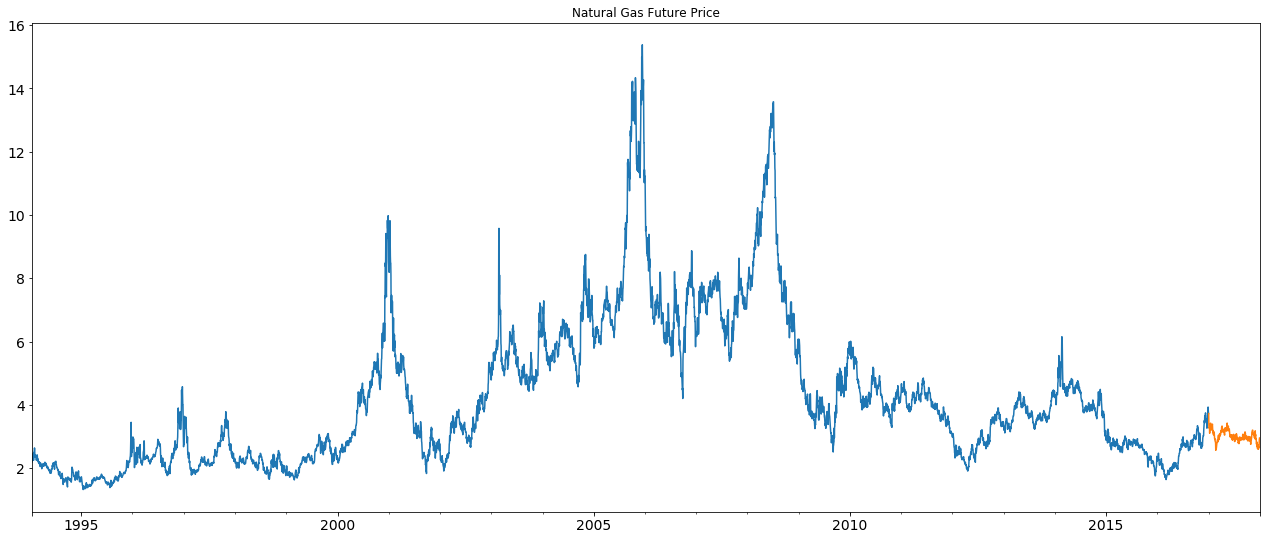

In [35]:
train.Price.plot(figsize=(22,9), title= 'Natural Gas Future Price', fontsize=14)
test.Price.plot(figsize=(22,9), title= 'Natural Gas Future Price', fontsize=14)
plt.show()

#### 2.2 Time series analysis

In [36]:
import os
import sys

import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

In [37]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
p = print

In [38]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

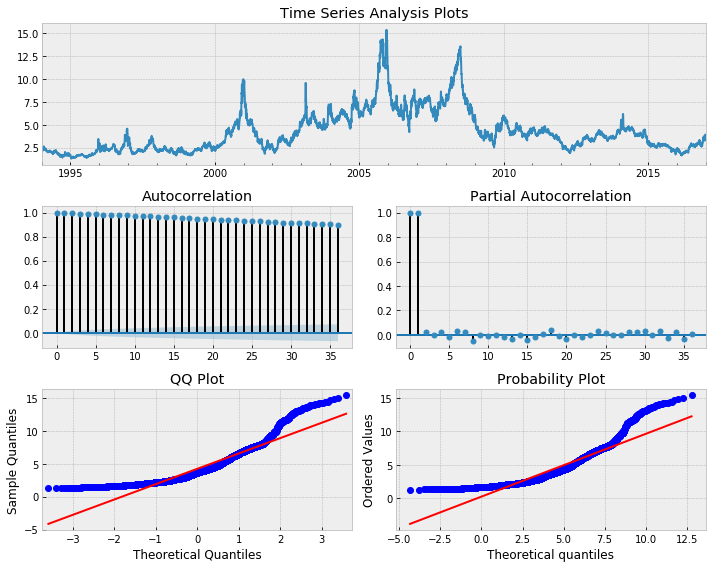

In [39]:
tsplot(train.Price, lags=36)

#### 2.3 ARIMA

In [40]:
from statsmodels.tsa.arima_model import ARIMA

In [41]:
model1 = ARIMA(df.Price, order=(1, 1, 1))
fit1 = model1.fit()
print(fit1.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Price   No. Observations:                 6251
Model:                 ARIMA(1, 1, 1)   Log Likelihood                2142.492
Method:                       css-mle   S.D. of innovations              0.172
Date:                Wed, 11 Apr 2018   AIC                          -4276.983
Time:                        19:58:51   BIC                          -4250.021
Sample:                    01-14-1994   HQIC                         -4267.639
                         - 12-29-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0001      0.002      0.058      0.954      -0.004       0.004
ar.L1.D.Price     0.6081      0.180      3.372      0.001       0.255       0.961
ma.L1.D.Price    -0.6299      0.176     

In [42]:
model2 = ARIMA(df.Price, order=(1,1,1))
fit2 = model2.fit(trend='nc')
print(fit2.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Price   No. Observations:                 6251
Model:                 ARIMA(1, 1, 1)   Log Likelihood                2142.490
Method:                       css-mle   S.D. of innovations              0.172
Date:                Wed, 11 Apr 2018   AIC                          -4278.980
Time:                        19:58:54   BIC                          -4258.758
Sample:                    01-14-1994   HQIC                         -4271.972
                         - 12-29-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ar.L1.D.Price     0.6081      0.180      3.372      0.001       0.255       0.962
ma.L1.D.Price    -0.6299      0.176     -3.573      0.000      -0.975      -0.284
                                    Root

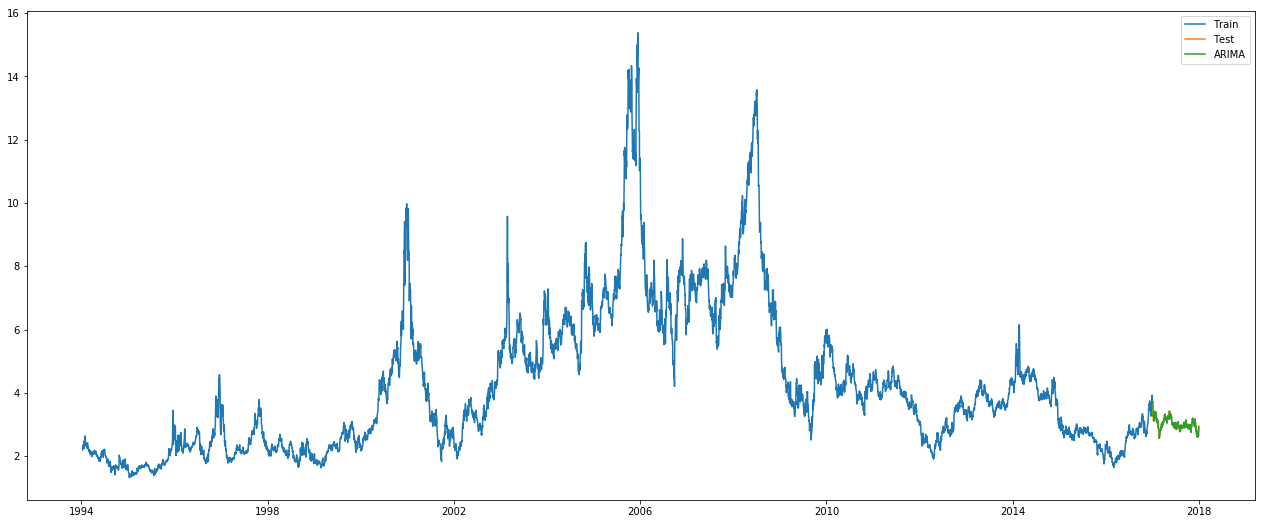

In [45]:
y_hat_avg = test.copy()
y_hat_avg['ARIMA'] = fit2.predict(test.index[0],test.index[-1],typ='levels')
plt.figure(figsize=(22,9))
plt.plot(train['Price'], label='Train')
plt.plot(test['Price'], label='Test')
plt.plot(y_hat_avg['ARIMA'], label='ARIMA')
plt.legend(loc='best')
plt.show()

In [46]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [47]:
rms = sqrt(mean_squared_error(test.Price, y_hat_avg.ARIMA))
print(rms)

0.0728251784632228


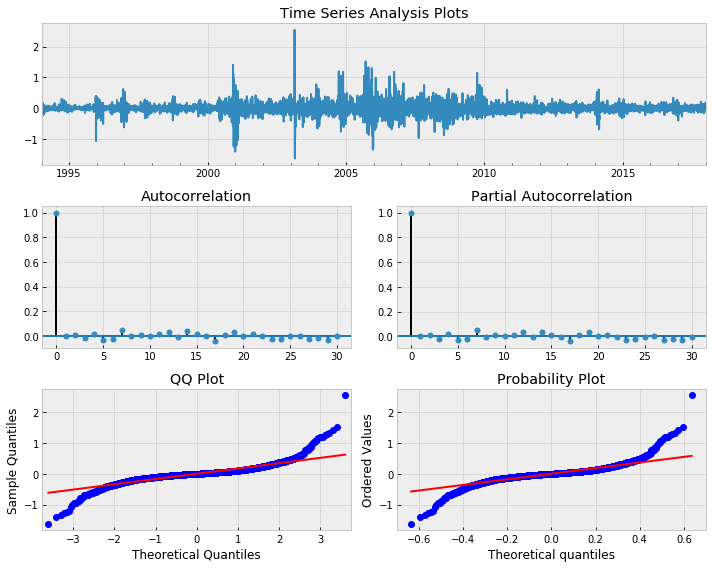

In [48]:
tsplot(fit2.resid, lags=30)

In [49]:
from matplotlib import pyplot

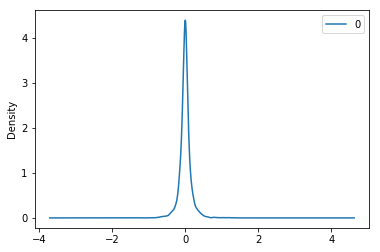

                 0
count  6251.000000
mean      0.000127
std       0.171769
min      -1.626668
25%      -0.063912
50%      -0.000656
75%       0.060292
max       2.543392


In [50]:
residuals = pd.DataFrame(fit2.resid)
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

#### 2.4 Simple Exponential Smoothing

In [51]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [52]:
model3 = SimpleExpSmoothing(np.asarray(df['Price']))
fit3 = model3.fit()
fit3.model.params['smoothing_level']

0.9776533839746111

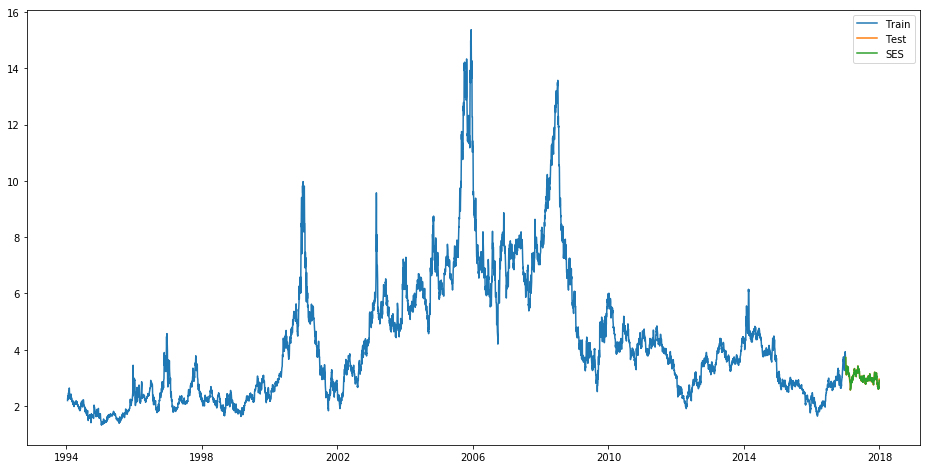

In [53]:
y_hat_avg3 = test.copy()
y_hat_avg3['SES'] = fit3.fittedvalues[5992:]
plt.figure(figsize=(16,8))
plt.plot(train['Price'], label='Train')
plt.plot(test['Price'], label='Test')
plt.plot(y_hat_avg3['SES'], label='SES')
plt.legend(loc='best')
plt.show()

In [54]:
rms = sqrt(mean_squared_error(test.Price, y_hat_avg3.SES))
print(rms)

0.0728712652480168


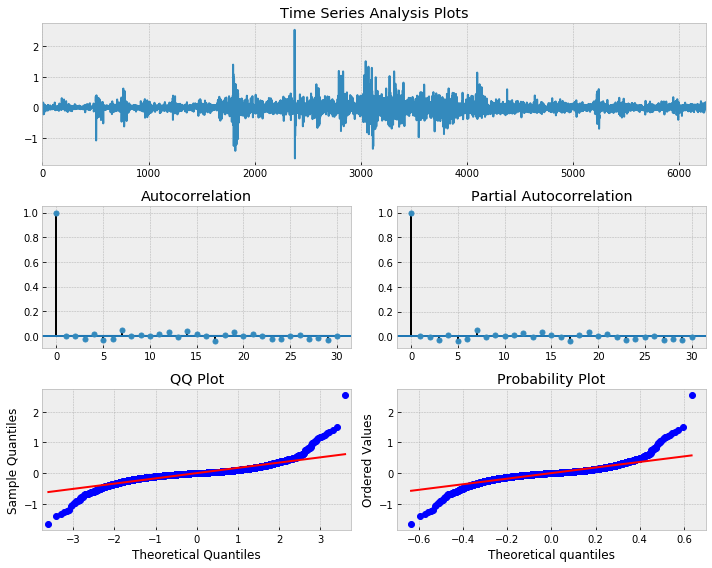

In [55]:
tsplot(fit3.resid, lags=30)

#### 2.5 Holt's linear Smoothing

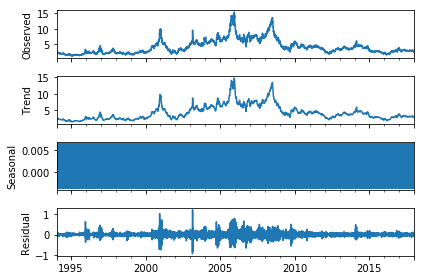

In [56]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(df.Price).plot()
result = sm.tsa.stattools.adfuller(df.Price)
plt.show()

In [57]:
model4 = Holt(np.asarray(df['Price']))
fit4 = model4.fit()
print(fit4.model.params['smoothing_level'])
print(fit4.model.params['smoothing_slope'])

1.0
0.0


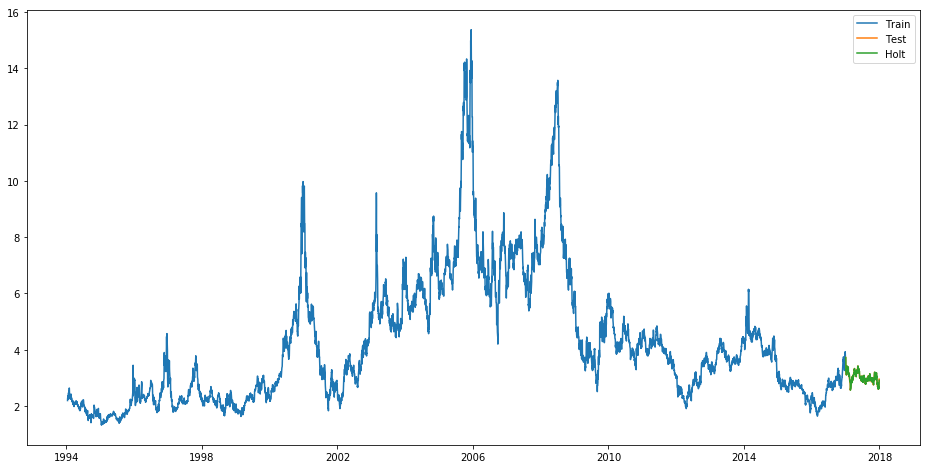

In [58]:
y_hat_avg4 = test.copy()
y_hat_avg4['Holt'] = fit4.fittedvalues[5992:]
plt.figure(figsize=(16,8))
plt.plot(train['Price'], label='Train')
plt.plot(test['Price'], label='Test')
plt.plot(y_hat_avg4['Holt'], label='Holt')
plt.legend(loc='best')
plt.show()

In [59]:
rms = sqrt(mean_squared_error(test.Price, y_hat_avg4.Holt))
print(rms)

0.07293266124942295


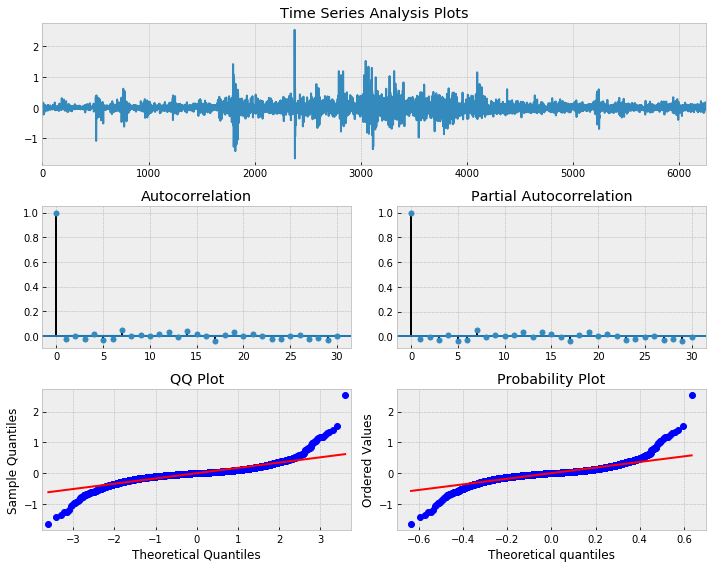

In [60]:
tsplot(fit4.resid, lags=30)

#### 2.6 Backtesting

For ARIMA Model

In [61]:
result = test.copy()
result['ARIMA']=np.nan
j = 0

In [62]:
for i in range (5992,6252):
    forecast = ARIMA(df.Price[0:i], order=(1,1,1)).fit(trend='nc').forecast()[0]
    result.iloc[j,2]=forecast
    j = j+1

result.head()

Day  Price     ARIMA
2017-01-02  2017-01-02  3.724  3.725091
2017-01-03  2017-01-03  3.327  3.724682
2017-01-04  2017-01-04  3.267  3.335980
2017-01-05  2017-01-05  3.273  3.273891
2017-01-06  2017-01-06  3.285  3.277196

In [63]:
rms = sqrt(mean_squared_error(result.Price, result.ARIMA))
print(rms)

0.07282762159490226


In [64]:
result['Price'].corr(result['ARIMA'])

0.92241586830767808

For Simple Exponential Smoothing

In [65]:
result['SES']=np.nan
j = 0

In [66]:
result.head()

Day  Price     ARIMA  SES
2017-01-02  2017-01-02  3.724  3.725091  NaN
2017-01-03  2017-01-03  3.327  3.724682  NaN
2017-01-04  2017-01-04  3.267  3.335980  NaN
2017-01-05  2017-01-05  3.273  3.273891  NaN
2017-01-06  2017-01-06  3.285  3.277196  NaN

In [67]:
for i in range (5992,6252):
    forecast = SimpleExpSmoothing(np.asarray(df.Price[0:i])).fit().forecast(1)
    result.iloc[j,3]=forecast
    j = j+1
    
result.head()

Day  Price     ARIMA       SES
2017-01-02  2017-01-02  3.724  3.725091  3.725788
2017-01-03  2017-01-03  3.327  3.724682  3.724040
2017-01-04  2017-01-04  3.267  3.335980  3.335790
2017-01-05  2017-01-05  3.273  3.273891  3.268511
2017-01-06  2017-01-06  3.285  3.277196  3.272901

In [68]:
rms = sqrt(mean_squared_error(result.Price, result.SES))
print(rms)

0.07287240049604032


In [69]:
result['Price'].corr(result['SES'])

0.92244000436881168

For Holt Linear Smoothing

In [81]:
result['Holt']=np.nan
j = 0

In [82]:
result.head()

Day  Price     ARIMA       SES  Holt
2017-01-02  2017-01-02  3.724  3.725091  3.725788   NaN
2017-01-03  2017-01-03  3.327  3.724682  3.724040   NaN
2017-01-04  2017-01-04  3.267  3.335980  3.335790   NaN
2017-01-05  2017-01-05  3.273  3.273891  3.268511   NaN
2017-01-06  2017-01-06  3.285  3.277196  3.272901   NaN

In [83]:
for i in range (5992,6252):
    forecast = Holt(np.asarray(df.Price[0:i])).fit().forecast(1)
    result.iloc[j,4]=forecast
    j = j+1
    
result.head()

Day  Price     ARIMA       SES   Holt
2017-01-02  2017-01-02  3.724  3.725091  3.725788  3.724
2017-01-03  2017-01-03  3.327  3.724682  3.724040  3.724
2017-01-04  2017-01-04  3.267  3.335980  3.335790  3.327
2017-01-05  2017-01-05  3.273  3.273891  3.268511  3.267
2017-01-06  2017-01-06  3.285  3.277196  3.272901  3.273

In [84]:
rms = sqrt(mean_squared_error(result.Price, result.Holt))
print(rms)

0.07293266124942292


In [85]:
result['Price'].corr(result['Holt'])

0.92240388872124535

### Part 3 Strategy

#### Stratehy 1

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARIMA

In [2]:
df=pd.read_csv('gas5.csv')
df.Timestamp=pd.date_range('1994-01-13', periods=6283, freq='B')
df.index=df.Timestamp
df.index

DatetimeIndex(['1994-01-13', '1994-01-14', '1994-01-17', '1994-01-18',
               '1994-01-19', '1994-01-20', '1994-01-21', '1994-01-24',
               '1994-01-25', '1994-01-26',
               ...
               '2018-01-30', '2018-01-31', '2018-02-01', '2018-02-02',
               '2018-02-05', '2018-02-06', '2018-02-07', '2018-02-08',
               '2018-02-09', '2018-02-12'],
              dtype='datetime64[ns]', length=6283, freq='B')

In [6]:
#Confidence level = 70%, 7-step from 1994-01-13 to 2017-01-02
forecast5 = ARIMA(df.Price[0:5993], order=(1,1,1)).fit(trend='nc').forecast(steps=7, alpha=0.05)

In [7]:
#Confidence level = 70%, 1-step
forecast6 = ARIMA(df.Price[0:5994], order=(1,1,1)).fit(trend='nc').forecast(steps=1, alpha=1)

In [8]:
#Lower bound
forecast5[2][6]

array([ 2.85138693,  4.59994892])

In [77]:
#Upper bound
forecast6[2][0][1]

3.3359795809747728

In [78]:
#Price on 2017-01-02 and 2017-01-03
df[5992:5994]

Day  Price
2017-01-02  2017-01-02  3.724
2017-01-03  2017-01-03  3.327

In [3]:
def forecast_7_buy(price, dataframe, alpha):
    a = ARIMA(dataframe, order=(1,1,1)).fit(trend='nc').forecast(steps=7, alpha=alpha)
    if price <= a[2][6][0]:
        return('buy')
    else:
        return('no buy')

In [4]:
def forecast_7_sell(price, dataframe, alpha):
    a = ARIMA(dataframe, order=(1,1,1)).fit(trend='nc').forecast(steps=7, alpha=alpha)
    if price >= a[2][6][1]:
        return('sell')
    else:
        return('no sell')

In [5]:
def buy_reverse(price, dataframe, alpha):
    a = ARIMA(dataframe, order=(1,1,1)).fit(trend='nc').forecast(steps=1, alpha=alpha)
    if price >= a[2][0][1]:
        return('reverse buy')
    else:
        return('no reverse buy')

In [6]:
def sell_reverse(price, dataframe, alpha):
    a = ARIMA(dataframe, order=(1,1,1)).fit(trend='nc').forecast(steps=1, alpha=alpha)
    if price <= a[2][0][0]:
        return('reverse sell')
    else:
        return('no reverse sell')

In [7]:
#Price on 2017-01-02 and 2017-01-03
df[5992:5994]

Day  Price
2017-01-02  02/01/2017  3.724
2017-01-03  03/01/2017  3.327

In [7]:
result = df[5992:].copy()
result['buy']=np.nan #2
result['buy_r']=np.nan #3
result['profit']=np.nan #4
result['sell']=np.nan #5
result['sell_r']=np.nan #6
result['profit2']=np.nan #7

In [77]:
###
for i in range(0, 260):
    result.iloc[i,2] = forecast_7_buy(result.iloc[i,1], df.Price[0:i+5993], 1)
    result.iloc[i,5] = forecast_7_sell(result.iloc[i,1], df.Price[0:i+5993], 1)
    if result.iloc[i,2] == 'buy':
        for j in range(1,31):
            if j in range(1,8):
                t = buy_reverse(result.iloc[i+j,1], df.Price[0:i+j+5992], 0.3)
                if t == 'reverse buy':
                    result.iloc[i,3] = result.iloc[i+j,0]
                    result.iloc[i,4] = result.iloc[i+j,1]-result.iloc[i,1]
                    break
            elif j in range(8,15):
                t = buy_reverse(result.iloc[i+j,1], df.Price[0:i+j+5992], 0.4)
                if t == 'reverse buy':
                    result.iloc[i,3] = result.iloc[i+j,0]
                    result.iloc[i,4] = result.iloc[i+j,1]-result.iloc[i,1]
                    break
            elif j in range(15,22):
                t = buy_reverse(result.iloc[i+j,1], df.Price[0:i+j+5992], 0.7)
                if t == 'reverse buy':
                    result.iloc[i,3] = result.iloc[i+j,0]
                    result.iloc[i,4] = result.iloc[i+j,1]-result.iloc[i,1]
                    break
            else:
                result.iloc[i,3] = result.iloc[i+30,0]
                result.iloc[i,4] = result.iloc[i+30,1]-result.iloc[i,1]
    elif result.iloc[i,5] == 'sell':
        for j in range(1,31):
            if j in range(1,8):
                t = sell_reverse(result.iloc[i+j,1], df.Price[0:i+j+5992], 0.3)
                if t == 'reverse sell':
                    result.iloc[i,6] = result.iloc[i+j,0]
                    result.iloc[i,7] = -result.iloc[i+j,1]+result.iloc[i,1]
                    break
            elif j in range(8,15):
                t = sell_reverse(result.iloc[i+j,1], df.Price[0:i+j+5992], 0.4)
                if t == 'reverse sell':
                    result.iloc[i,6] = result.iloc[i+j,0]
                    result.iloc[i,7] = -result.iloc[i+j,1]+result.iloc[i,1]
                    break
            elif j in range(15,22):
                t = sell_reverse(result.iloc[i+j,1], df.Price[0:i+j+5992], 0.7)
                if t == 'reverse sell':
                    result.iloc[i,6] = result.iloc[i+j,0]
                    result.iloc[i,7] = -result.iloc[i+j,1]+result.iloc[i,1]
                    break
            else:
                result.iloc[i,6] = result.iloc[i+30,0]
                result.iloc[i,7] = -result.iloc[i+30,1]+result.iloc[i,1]

/Users/shaozhao/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/shaozhao/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/shaozhao/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [78]:
result

Day  Price     buy       buy_r  profit     sell  \
2017-01-02  02/01/2017  3.724     buy  12/01/2017  -0.338  no sell   
2017-01-03  03/01/2017  3.327     buy  14/02/2017  -0.422  no sell   
2017-01-04  04/01/2017  3.267     buy  15/02/2017  -0.342  no sell   
2017-01-05  05/01/2017  3.273     buy  16/02/2017  -0.419  no sell   
2017-01-06  06/01/2017  3.285     buy  17/02/2017  -0.451  no sell   
2017-01-09  09/01/2017  3.103     buy  07/02/2017   0.027  no sell   
2017-01-10  10/01/2017  3.278  no buy         NaN     NaN     sell   
2017-01-11  11/01/2017  3.224     buy  07/02/2017  -0.094  no sell   
2017-01-12  12/01/2017  3.386  no buy         NaN     NaN     sell   
2017-01-13  13/01/2017  3.419  no buy         NaN     NaN     sell   
2017-01-16  16/01/2017  3.419  no buy         NaN     NaN     sell   
2017-01-17  17/01/2017  3.412  no buy         NaN     NaN     sell   
2017-01-18  18/01/2017  3.302     buy  01/03/2017  -0.503  no sell   
2017-01-19  19/01/2017  3.368  no buy         NaN     NaN     sell   
2017-01-20  20/01/2017  3.204     buy  03/03/2017  -0.377  no sell   
2017-01-23  23/01/2017  3.243     buy  06/03/2017  -0.342  no sell   
2017-01-24  24/01/2017  3.279     buy  07/03/2017  -0.455  no sell   
2017-01-25  25/01/2017  3.332  no buy         NaN     NaN     sell   
2017-01-26  26/01/2017  3.382  no buy         NaN     NaN     sell   
2017-01-27  27/01/2017  3.391  no buy         NaN     NaN     sell   
2017-01-30  30/01/2017  3.232     buy  28/02/2017  -0.458  no sell   
2017-01-31  31/01/2017  3.117     buy  28/02/2017  -0.343  no sell   
2017-02-01  01/02/2017  3.168     buy  28/02/2017  -0.394  no sell   
2017-02-02  02/02/2017  3.187     buy  28/02/2017  -0.413  no sell   
2017-02-03  03/02/2017  3.063     buy  28/02/2017  -0.289  no sell   
2017-02-06  06/02/2017  3.050     buy  28/02/2017  -0.276  no sell   
2017-02-07  07/02/2017  3.130  no buy         NaN     NaN     sell   
2017-02-08  08/02/2017  3.126  no buy         NaN     NaN     sell   
2017-02-09  09/02/2017  3.141  no buy         NaN     NaN     sell   
2017-02-10  10/02/2017  3.034     buy  06/03/2017  -0.133  no sell   
...                ...    ...     ...         ...     ...      ...   
2018-01-02  02/01/2018  3.056     NaN         NaN     NaN      NaN   
2018-01-03  03/01/2018  3.008     NaN         NaN     NaN      NaN   
2018-01-04  04/01/2018  2.880     NaN         NaN     NaN      NaN   
2018-01-05  05/01/2018  2.795     NaN         NaN     NaN      NaN   
2018-01-08  08/01/2018  2.835     NaN         NaN     NaN      NaN   
2018-01-09  09/01/2018  2.923     NaN         NaN     NaN      NaN   
2018-01-10  10/01/2018  2.906     NaN         NaN     NaN      NaN   
2018-01-11  11/01/2018  3.084     NaN         NaN     NaN      NaN   
2018-01-12  12/01/2018  3.200     NaN         NaN     NaN      NaN   
2018-01-15  15/01/2018  3.200     NaN         NaN     NaN      NaN   
2018-01-16  16/01/2018  3.129     NaN         NaN     NaN      NaN   
2018-01-17  17/01/2018  3.232     NaN         NaN     NaN      NaN   
2018-01-18  18/01/2018  3.189     NaN         NaN     NaN      NaN   
2018-01-19  19/01/2018  3.185     NaN         NaN     NaN      NaN   
2018-01-22  22/01/2018  3.224     NaN         NaN     NaN      NaN   
2018-01-23  23/01/2018  3.444     NaN         NaN     NaN      NaN   
2018-01-24  24/01/2018  3.509     NaN         NaN     NaN      NaN   
2018-01-25  25/01/2018  3.447     NaN         NaN     NaN      NaN   
2018-01-26  26/01/2018  3.505     NaN         NaN     NaN      NaN   
2018-01-29  29/01/2018  3.631     NaN         NaN     NaN      NaN   
2018-01-30  30/01/2018  3.195     NaN         NaN     NaN      NaN   
2018-01-31  31/01/2018  2.995     NaN         NaN     NaN      NaN   
2018-02-01  01/02/2018  2.856     NaN         NaN     NaN      NaN   
2018-02-02  02/02/2018  2.846     NaN         NaN     NaN      NaN   
2018-02-05  05/02/2018  2.747     NaN         NaN     NaN      NaN   
2018-02-06  06/02/2018  2.759

In [79]:
result.profit.sum()+result.profit2.sum()

10.396000000000008

In [80]:
pd.to_datetime(result.iloc[4,0]).day

1

### Part 4: Risk Control

In [ ]:
result = df[5992:].copy()
result['buy']=np.nan #2
result['buy_r']=np.nan #3
result['profit']=np.nan #4
result['sell']=np.nan #5
result['sell_r']=np.nan #6
result['profit2']=np.nan #7

In [8]:
###
for i in range(0, 260):
    result.iloc[i,2] = forecast_7_buy(result.iloc[i,1], df.Price[0:i+5993], 1)
    result.iloc[i,5] = forecast_7_sell(result.iloc[i,1], df.Price[0:i+5993], 1)
    if result.iloc[i,2] == 'buy':
        for j in range(1,31):
            if j in range(1,8):
                t = buy_reverse(result.iloc[i+j,1], df.Price[0:i+j+5992], 0.3)
                if t == 'reverse buy' and (result.iloc[i+j,1]/result.iloc[i,1])>=1:
                    result.iloc[i,3] = result.iloc[i+j,0]
                    result.iloc[i,4] = result.iloc[i+j,1]-result.iloc[i,1]
                    break
            elif j in range(8,15):
                t = buy_reverse(result.iloc[i+j,1], df.Price[0:i+j+5992], 0.4)
                if t == 'reverse buy' and (result.iloc[i+j,1]/result.iloc[i,1])>=1:
                    result.iloc[i,3] = result.iloc[i+j,0]
                    result.iloc[i,4] = result.iloc[i+j,1]-result.iloc[i,1]
                    break
            elif j in range(15,22):
                t = buy_reverse(result.iloc[i+j,1], df.Price[0:i+j+5992], 0.7)
                if t == 'reverse buy' and (result.iloc[i+j,1]/result.iloc[i,1])>=0.9:
                    result.iloc[i,3] = result.iloc[i+j,0]
                    result.iloc[i,4] = result.iloc[i+j,1]-result.iloc[i,1]
                    break
            else:
                result.iloc[i,3] = result.iloc[i+30,0]
                result.iloc[i,4] = result.iloc[i+30,1]-result.iloc[i,1]
    elif result.iloc[i,5] == 'sell':
        for j in range(1,31):
            if j in range(1,8):
                t = sell_reverse(result.iloc[i+j,1], df.Price[0:i+j+5992], 0.3)
                if t == 'reverse sell' and (result.iloc[i,1]/result.iloc[i+j,1])>=1:
                    result.iloc[i,6] = result.iloc[i+j,0]
                    result.iloc[i,7] = -result.iloc[i+j,1]+result.iloc[i,1]
                    break
            elif j in range(8,15):
                t = sell_reverse(result.iloc[i+j,1], df.Price[0:i+j+5992], 0.4)
                if t == 'reverse sell' and (result.iloc[i,1]/result.iloc[i+j,1])>=1:
                    result.iloc[i,6] = result.iloc[i+j,0]
                    result.iloc[i,7] = -result.iloc[i+j,1]+result.iloc[i,1]
                    break
            elif j in range(15,22):
                t = sell_reverse(result.iloc[i+j,1], df.Price[0:i+j+5992], 0.7)
                if t == 'reverse sell' and (result.iloc[i,1]/result.iloc[i+j,1])>=0.9:
                    result.iloc[i,6] = result.iloc[i+j,0]
                    result.iloc[i,7] = -result.iloc[i+j,1]+result.iloc[i,1]
                    break
            else:
                result.iloc[i,6] = result.iloc[i+30,0]
                result.iloc[i,7] = -result.iloc[i+30,1]+result.iloc[i,1]

/Users/shaozhao/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/shaozhao/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/shaozhao/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [9]:
result.profit.sum()+result.profit2.sum()

10.72900000000001

In [10]:
result

Day  Price     buy       buy_r  profit     sell  \
2017-01-02  02/01/2017  3.724     buy  13/02/2017  -0.780  no sell   
2017-01-03  03/01/2017  3.327     buy  14/02/2017  -0.422  no sell   
2017-01-04  04/01/2017  3.267     buy  15/02/2017  -0.342  no sell   
2017-01-05  05/01/2017  3.273     buy  16/02/2017  -0.419  no sell   
2017-01-06  06/01/2017  3.285     buy  17/02/2017  -0.451  no sell   
2017-01-09  09/01/2017  3.103     buy  07/02/2017   0.027  no sell   
2017-01-10  10/01/2017  3.278  no buy         NaN     NaN     sell   
2017-01-11  11/01/2017  3.224     buy  07/02/2017  -0.094  no sell   
2017-01-12  12/01/2017  3.386  no buy         NaN     NaN     sell   
2017-01-13  13/01/2017  3.419  no buy         NaN     NaN     sell   
2017-01-16  16/01/2017  3.419  no buy         NaN     NaN     sell   
2017-01-17  17/01/2017  3.412  no buy         NaN     NaN     sell   
2017-01-18  18/01/2017  3.302     buy  01/03/2017  -0.503  no sell   
2017-01-19  19/01/2017  3.368  no buy         NaN     NaN     sell   
2017-01-20  20/01/2017  3.204     buy  03/03/2017  -0.377  no sell   
2017-01-23  23/01/2017  3.243     buy  06/03/2017  -0.342  no sell   
2017-01-24  24/01/2017  3.279     buy  07/03/2017  -0.455  no sell   
2017-01-25  25/01/2017  3.332  no buy         NaN     NaN     sell   
2017-01-26  26/01/2017  3.382  no buy         NaN     NaN     sell   
2017-01-27  27/01/2017  3.391  no buy         NaN     NaN     sell   
2017-01-30  30/01/2017  3.232     buy  13/03/2017  -0.189  no sell   
2017-01-31  31/01/2017  3.117     buy  14/03/2017  -0.179  no sell   
2017-02-01  01/02/2017  3.168     buy  15/03/2017  -0.187  no sell   
2017-02-02  02/02/2017  3.187     buy  16/03/2017  -0.285  no sell   
2017-02-03  03/02/2017  3.063     buy  28/02/2017  -0.289  no sell   
2017-02-06  06/02/2017  3.050     buy  28/02/2017  -0.276  no sell   
2017-02-07  07/02/2017  3.130  no buy         NaN     NaN     sell   
2017-02-08  08/02/2017  3.126  no buy         NaN     NaN     sell   
2017-02-09  09/02/2017  3.141  no buy         NaN     NaN     sell   
2017-02-10  10/02/2017  3.034     buy  06/03/2017  -0.133  no sell   
...                ...    ...     ...         ...     ...      ...   
2018-01-02  02/01/2018  3.056     NaN         NaN     NaN      NaN   
2018-01-03  03/01/2018  3.008     NaN         NaN     NaN      NaN   
2018-01-04  04/01/2018  2.880     NaN         NaN     NaN      NaN   
2018-01-05  05/01/2018  2.795     NaN         NaN     NaN      NaN   
2018-01-08  08/01/2018  2.835     NaN         NaN     NaN      NaN   
2018-01-09  09/01/2018  2.923     NaN         NaN     NaN      NaN   
2018-01-10  10/01/2018  2.906     NaN         NaN     NaN      NaN   
2018-01-11  11/01/2018  3.084     NaN         NaN     NaN      NaN   
2018-01-12  12/01/2018  3.200     NaN         NaN     NaN      NaN   
2018-01-15  15/01/2018  3.200     NaN         NaN     NaN      NaN   
2018-01-16  16/01/2018  3.129     NaN         NaN     NaN      NaN   
2018-01-17  17/01/2018  3.232     NaN         NaN     NaN      NaN   
2018-01-18  18/01/2018  3.189     NaN         NaN     NaN      NaN   
2018-01-19  19/01/2018  3.185     NaN         NaN     NaN      NaN   
2018-01-22  22/01/2018  3.224     NaN         NaN     NaN      NaN   
2018-01-23  23/01/2018  3.444     NaN         NaN     NaN      NaN   
2018-01-24  24/01/2018  3.509     NaN         NaN     NaN      NaN   
2018-01-25  25/01/2018  3.447     NaN         NaN     NaN      NaN   
2018-01-26  26/01/2018  3.505     NaN         NaN     NaN      NaN   
2018-01-29  29/01/2018  3.631     NaN         NaN     NaN      NaN   
2018-01-30  30/01/2018  3.195     NaN         NaN     NaN      NaN   
2018-01-31  31/01/2018  2.995     NaN         NaN     NaN      NaN   
2018-02-01  01/02/2018  2.856     NaN         NaN     NaN      NaN   
2018-02-02  02/02/2018  2.846     NaN         NaN     NaN      NaN   
2018-02-05  05/02/2018  2.747     NaN         NaN     NaN      NaN   
2018-02-06  06/02/2018  2.759